# Multi-variate communication with pointers

This sketch shows how a single wire can transmit an array through a pointer. Only the readout and dynamics function is used to transmit the information.

In [54]:
# Libraries
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Plots
using Plots.PlotMeasures
using DifferentialEquations

In [55]:
show_diagram(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  )
);

### Part 1 - Two boxes

Consider a basic system with two boxes communicating with each other. The wire will transmit the entire state of box1 into box2. 

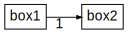

In [56]:
# Closed diagram
diagram = WiringDiagram( [], [] ); 

# Boxes
box1 = add_box!( diagram, Box(:box1, [], [:1]) );
box2 = add_box!( diagram, Box(:box2, [:1], []) );

# Connections
add_wires!(diagram, [
    (box1,1) => (box2,1)
])

show_diagram(diagram)

Assume each box contains a spring-mass system. We can define the behavior of this system through a set coefficients. We can also define the initial conditions for which we will solve the system.

In [57]:
#- Coefficients
# Mass #1
k1 = 1;     
c1 = 1;

# Mass #2
k2 = 1; 
c2 = 4;

# Parameters for ODE Solver:
u_init = [1, 0, 1, 0];       # Initial conditions: [x1, v1, x2, v2]
t_span = (0, 20);            # Interval of solution

# Miscellaneous:
const N_STATES = 2;          # Number of states transmitter per wire

A single wire can only transfer a scalar value. In light of this, instead of transmitting an element of the state vector, we can instead transmit the pointer to the state vector.  

Unfortuately the readout function must output the same type as the continuous machine. To overcome this, one can output the address of pointer as a number. Within the dynamics function the address is converted back into a pointer and used to access the values of the state vector. 

In [1]:
#- Readout functions: r(u)
function readout1(u) 
    # Transform variable address into float
    return [ Float64( UInt64(pointer(u)) ) ];     
end

function readout2(u) 
    return [];    
end

#- Input Functions: 
function equation1(u, x, p, t) 
    return [ u[2], -k1*u[1] - c1*u[2] ];   
end

function equation2(u, x, p, t) 
    # Transform address into pointer
    pt = Ptr{Float64}( UInt64(x[1]) );    
    
    # Get vector from decoded pointer
    x = unsafe_wrap(Vector{Float64}, pt, N_STATES, own=false);

    return [ u[2], -k2*(u[1]-x[1]) - c2*(u[2] - x[2]) ];  # Access the elements of the vector associated to the pointer.
end

equation2 (generic function with 1 method)

This scheme succesfully transfers the information of one box to the other. This is evident in the graph as the response of the 2nd box is damped.

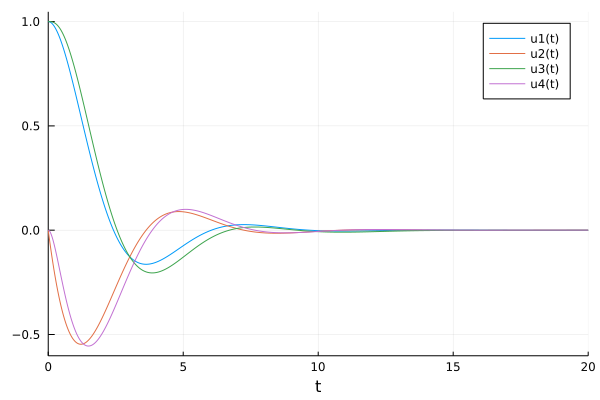

In [59]:
# Machines:
                                  # Inputs, States, Outputs
box1_machine = ContinuousMachine{Float64}( 0, 2, 1, equation1, readout1 );    
box2_machine = ContinuousMachine{Float64}( 1, 2, 0, equation2, readout2 );  

# Compose
net_machine = oapply(diagram, [box1_machine, box2_machine]);

# Convert into ODE form:
data = ODEProblem(net_machine, u_init, t_span);

# Solve and plot system
sol = solve( data, alg_hints=[:stiff] );
plot(sol)

#### Two boxes with feedback

The example can be modifed to have the boxes communicate with each other. It is the same logic and there essentially no change in the code.

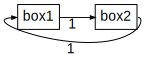

In [60]:
# Closed diagram
diagram = WiringDiagram( [], [] ); 

# Boxes
box1 = add_box!( diagram, Box(:box1, [:1], [:1]) );
box2 = add_box!( diagram, Box(:box2, [:1], [:1]) );

# Connections
add_wires!(diagram, [
    (box1,1) => (box2,1)
    (box2,1) => (box1,1)
])

show_diagram(diagram)

Both readout functions must output the pointer of the state. The readout and dynamics functions are the same for both boxes as they have the same number of inputs and outputs.

In [61]:
#- Readout functions: r(u)
function readout1(u)
    return [ Float64( UInt64(pointer(u)) ) ];   # Each box outputs its state as a pointer
end

function readout2(u)
    return [ Float64( UInt64(pointer(u)) ) ];
end

#- Input Functions: 
common_term(u, x) = k2*(x[1] - u[1]) + c2*(x[2] - u[2]);     
                        
function equation1(u, x, p, t) # Each equation must decode the input
    # Input 1:
    pt = Ptr{Float64}( UInt64(x[1]) );    
    x = unsafe_wrap(Vector{Float64}, pt, N_STATES, own=false);
    
    return [ u[2], -k1*u[1] - c1*u[2] + common_term(u,x)];   
end

function equation2(u, x, p, t) 
    # Input 1:
    pt = Ptr{Float64}( UInt64(x[1]) );    
    x = unsafe_wrap(Vector{Float64}, pt, N_STATES, own=false);   
    
    return [ u[2], common_term(u,x) ]; 
end

equation2 (generic function with 1 method)

As might be expected, the behavior is only slighly different from the first case. Due to the feedback, the effective
damping of the system decreases.

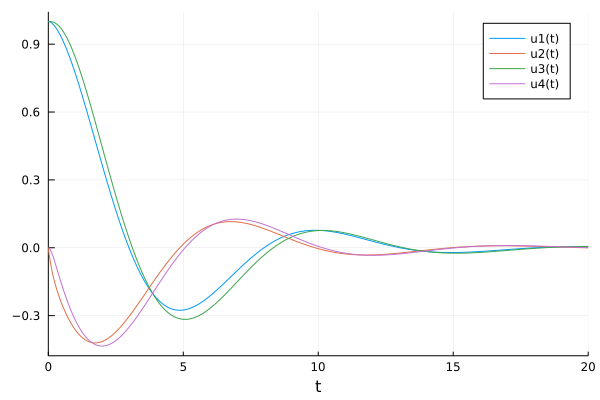

In [62]:
# Machines:
                                  # Inputs, States, Outputs
box1_machine = ContinuousMachine{Float64}( 1, 2, 1, equation1, readout1 );    
box2_machine = ContinuousMachine{Float64}( 1, 2, 1, equation2, readout2 );  

# Compose
net_machine = oapply(diagram, [box1_machine, box2_machine]);

# Convert into ODE form:
data = ODEProblem(net_machine, u_init, t_span);

# Solve and plot system
sol = solve( data, alg_hints=[:stiff] );
plot(sol)

### Part 2 - Multiple inputs

Let us explore what happens if one of the boxes has multiple inputs. For simplicy, consider a box that has two inputs from two boxes.

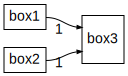

In [63]:
# Closed diagram
diagram = WiringDiagram( [], [] ); 

# Boxes
box1 = add_box!( diagram, Box(:box1, [], [:1]) );
box2 = add_box!( diagram, Box(:box2, [], [:1]) );
box3 = add_box!( diagram, Box(:box3, [:1, :2], []) );

# Connections
add_wires!(diagram, [
    (box1,1) => (box3,1)
    (box2,1) => (box3,2)
])

show_diagram(diagram)

The dynamics function of the 3rd box must decode both signals. It must take the pointer of each input and convert them into vectors, and the net input is the combination of both of these vectors. The order in which these vectors are combined is dictated by the diagram.

In [23]:
#- Readout functions: r(u)
function readout1(u) 
    return [ Float64( UInt64(pointer(u)) ) ];     # Box has a single output, hence a single element.
end

function readout2(u) 
    return [ Float64( UInt64(pointer(u)) ) ];    
end

function readout3(u) 
    return [];    
end

#- Input Functions: 
function equation1(u, x, p, t) # Functions have no inputs and so are simpler
    return [ u[2], -k1*u[1] - c1*u[2] ];   
end

function equation2(u, x, p, t) 
    return [ u[2], -k2*u[1] - c2*u[2] ];   
end

function equation3(u, x, p, t) # Each input must be decoded and a larger vector is defined as the input
    # Input 1:
    pt = Ptr{Float64}( UInt64(x[1]) );    
    x1 = unsafe_wrap(Vector{Float64}, pt, N_STATES, own=false);
    
    # Input 2:
    pt = Ptr{Float64}( UInt64(x[2]) ); 
    x2 = unsafe_wrap(Vector{Float64}, pt, N_STATES, own=false);
    
    # Net input
    x = [x1 x2];
    
    return [ u[2], -k2*(u[1] - x[1] + x[3]) - c2*(u[2] - x[2] + x[4]) ]; 
end

equation3 (generic function with 1 method)

As there are 3 boxes with two states, the total number of states is 6. This scheme has no issues transmitting all the states.

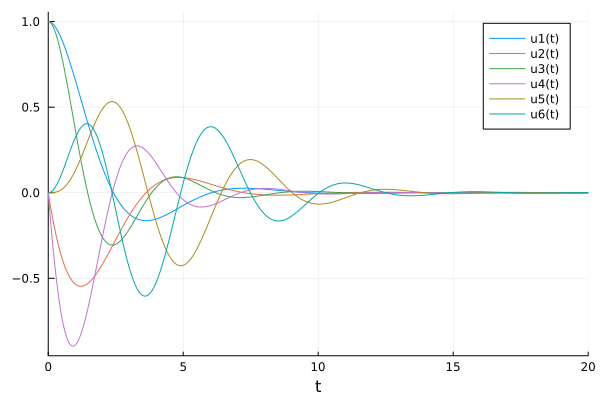

In [32]:
# Machines:
                                  # Inputs, States, Outputs
box1_machine = ContinuousMachine{Float64}( 0, 2, 1, equation1, readout1 );    
box2_machine = ContinuousMachine{Float64}( 0, 2, 1, equation2, readout2 );  
box3_machine = ContinuousMachine{Float64}( 2, 2, 0, equation3, readout3 );  

# Compose
net_machine = oapply(diagram, [box1_machine, box2_machine, box3_machine]);

# Parameters for ODE Solver:
u_init = [1, 0, 1, 0, 0, 0];       # Initial conditions: [x1, v1, x2, v2, x3, v3]

# Convert into ODE form:
data = ODEProblem(net_machine, u_init, t_span);

# Solve and plot system
sol = solve( data, alg_hints=[:stiff] );
plot(sol)

### Part 3 - Multiple outputs 

The readout and dynamics functions are very different when the diagram is reversed. Instead of receiving information, what happens if a box must output multiple values?

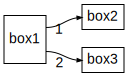

In [42]:
# Closed diagram
diagram = WiringDiagram( [], [] ); 

# Boxes
box1 = add_box!( diagram, Box(:box1, [], [:1, :2]) );
box2 = add_box!( diagram, Box(:box2, [:1], []) );
box3 = add_box!( diagram, Box(:box3, [:1], []) );

# Connections
add_wires!(diagram, [
    (box1,1) => (box2,1)
    (box1,2) => (box3,1)    
])

show_diagram(diagram)

The readout function of the first box must output a vector with two elements. This is dictated by the number of wires coming out of the box. Through each element of the wire one outputs the state of the box. The boxes receiving the inputs must convert the pointers into arrays.

In [43]:
#- Readout functions: r(u)
function readout1(u) 
    n = Float64( UInt64(pointer(u)) )
    return [n, n];                     # Two outputs, hence vector must have two elements. 
end

function readout2(u) 
    return [];                         # These boxes have no output, hence no elements.
end

function readout3(u)
    return [];    
end

#- Input Functions: 
function equation1(u, x, p, t)     
    return [ u[2], -k1*u[1] - c1*u[2] ]; 
end

function equation2(u, x, p, t)        # Only one input is recieved by the boxes
    #Input 1, output 1
    pt = Ptr{Float64}( UInt64(x[1]) );    
    x = unsafe_wrap(Vector{Float64}, pt, N_STATES, own=false);
    
    return [ u[2], -k1*(u[1]-x[1]) - c1*(u[2]-x[2]) ];   
end

function equation3(u, x, p, t) 
    # Input 1, output 2
    pt = Ptr{Float64}( UInt64(x[1]) );    
    x = unsafe_wrap(Vector{Float64}, pt, N_STATES, own=false);
    
    return [ u[2], -k2*(u[1]-x[1]) - c2*(u[2]-x[2]) ];   
end

equation3 (generic function with 1 method)

Like before this approach will succesfully transmit the information. However, it's important to notice that the readout and dynamics functions will change depending on the wiring diagram. 

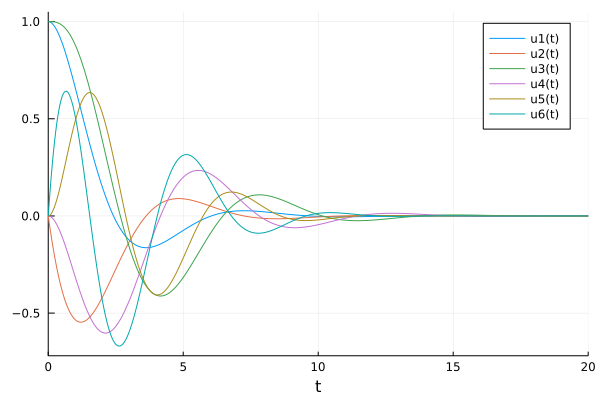

In [44]:
# Machines:
                                  # Inputs, States, Outputs
box1_machine = ContinuousMachine{Float64}( 0, 2, 2, equation1, readout1 );    
box2_machine = ContinuousMachine{Float64}( 1, 2, 0, equation2, readout2 );  
box3_machine = ContinuousMachine{Float64}( 1, 2, 0, equation3, readout3 );  

# Compose
net_machine = oapply(diagram, [box1_machine, box2_machine, box3_machine]);

# Convert into ODE form:
data = ODEProblem(net_machine, u_init, t_span);

# Solve and plot system
sol = solve( data, alg_hints=[:stiff] );
plot(sol)